# Complete Project Assembly

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install requests_toolbelt

In [26]:
import io
import cv2
import requests
from PIL import Image
from requests_toolbelt.multipart.encoder import MultipartEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os
import cv2
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
categories = ["unspecified_material","bleaching_any","bleaching_not",
              "bleaching_onlySome","drying_flat","drying_flat_drip","drying_flat_drip_shade","drying_flat_shade","drying_line",
              "drying_line_drip","drying_line_drip_shade","drying_line_shade","drying_tumble_lower_60","drying_tumble_normal_80","drying_tumble_not",
              "ironing_not","ironing_plate_110","ironing_plate_150","ironing_plate_200","professional_dry_mild_F","professional_dry_mild_P",
              "professional_dry_normal_F","professional_dry_normal_P","professional_dry_not","professional_wet_mild_W","professional_wet_normal_W",
              "professional_wet_not","professional_wet_veryMild_W","washing_hand_40","washing_mild_30","washing_mild_40","washing_mild_60",
              "washing_normal_30","washing_normal_40","washing_normal_60","washing_normal_95","washing_not","washing_veryMild_30","washing_veryMild_40"]

#### Loading Saved Classification Model for Oxwash Symbol Classification

In [28]:
Classification_Model = load_model('/content/drive/MyDrive/oxwash/code_files/saved_model/oxwash_classification_model.h5')

In [ ]:
Classification_Model.summary()

#### Using Bounding Boxes in the image

Function for Calculating $(x,y,w,h)$ for Image Cropping

In [3]:
def coordinates(lines,img):
  crop_list = []
  dh,dw,_ = img.shape
 
  for i in range(len(lines)):
    _, x, y, w, h = map(float, lines[i].split(' '))

    left = int((x - w / 2) * dw)      # x-cordinate
    width = int((x + w / 2) * dw)     # width
    top = int((y - h / 2) * dh)       # y-cordinate
    height = int((y + h / 2) * dh)    # height

    if left < 0:
      left = 0
    if width > dw - 1:
      width = dw - 1
    if top < 0:
      top = 0
    if height > dh - 1:
      height = dh - 1   

    ROI= img[top: height,  left: width ]

    crop_list.append(ROI)  

  return img , crop_list

##### Image path to perform Oxwash Symbol Detection

In [87]:
img_path = 'drive/MyDrive/oxwash/test_data/tag3.jpeg'

#### RoboFlow API for YOLO prediction

In [88]:
# Load Image with PIL
img = cv2.imread(img_path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilImage = Image.fromarray(image)

# Convert to JPEG Buffer
buffered = io.BytesIO()
pilImage.save(buffered, quality=100, format="JPEG")

# Build multipart form and post request
m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

response = requests.post("https://detect.roboflow.com/data1-bbgfd/2?api_key=55mb8QNoe37F5ENHgRZs", data=m, headers={'Content-Type': m.content_type})

print(response)
print(response.json())

<Response [200]>
{'predictions': [{'x': 83.0, 'y': 412.0, 'width': 62, 'height': 64, 'class': '0', 'confidence': 0.562}, {'x': 261.0, 'y': 315.5, 'width': 54, 'height': 63, 'class': '0', 'confidence': 0.55}, {'x': 199.0, 'y': 344.5, 'width': 56, 'height': 65, 'class': '0', 'confidence': 0.548}, {'x': 149.0, 'y': 386.0, 'width': 48, 'height': 64, 'class': '0', 'confidence': 0.532}, {'x': 317.0, 'y': 279.0, 'width': 50, 'height': 54, 'class': '0', 'confidence': 0.458}], 'image': {'width': 435, 'height': 772}}


In [89]:
line = []
cropped_images = []
for i in response.json()["predictions"]:
  line = []
  line.append(str(i["class"]) + " " + str(i["x"]) + " " + str(i["y"]) + " " + str(i["width"]) + " " + str(i["height"]))
  img , crop_list = coordinates(line,np.array(Image.open(img_path)))
  cropped_images.append(crop_list[0])  

 
print(f"Number of Cropped Images : {len(cropped_images)}")

5


#### Cells to prepare image data before feeding into 'Classification_Model'

In [96]:
def prepare_img_data(cropped_img):
  IMG_SIZE = 128

  grayscale_image = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

  new_array = cv2.resize(grayscale_image,(IMG_SIZE,IMG_SIZE))
  new_array = cv2.normalize(new_array, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
  
  return new_array.reshape(-1,IMG_SIZE,IMG_SIZE)

In [94]:
nd_images = []
for img in cropped_images:
  prepare_img = prepare_img_data(img)
  nd_images.append(prepare_img)

print(f"Number of Prepared Cropped Images : {len(nd_images)}")

5


#### Prediction Cell

In [104]:
img_label_dict = {}
for i in range(len(nd_images)):
  prediction = Classification_Model.predict(nd_images[i])
  prediction = prediction[0].astype('int') 
  prediction = prediction.tolist()
  try:
    prediction = prediction.index(max(prediction))
  except:
    prediction = 0
  img_label_dict[categories[prediction]] = cropped_images[i]
  

### Output Format : 

- dictionary = \{\<label : str\> : \<corresponding symbol image : ndarray\> \}
- Output variable : "img_label_dict" (type : dict)

#### Prediciton Display Cell

washing_veryMild_40


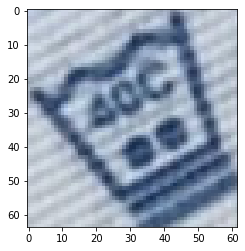

ironing_plate_150


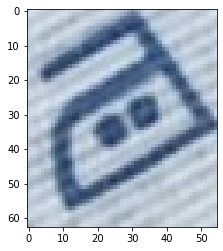

drying_tumble_normal_80


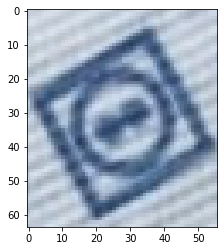

washing_normal_30


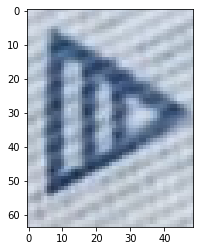

bleaching_onlySome


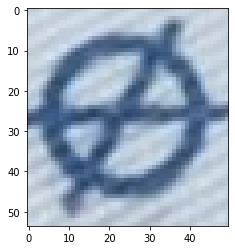

In [106]:
#print(len(img_label_dict))
for key in img_label_dict:
  print(str(key))
  plt.imshow(img_label_dict[key])
  plt.show()